The path is: /home/ucecabj/Desktop/MFI_git


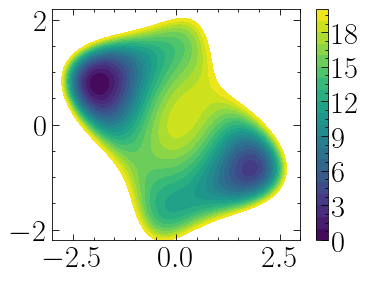

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import sys
import time
from matplotlib import colors
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LogNorm
from matplotlib import cm, ticker
from matplotlib.colors import LinearSegmentedColormap


if 'path' in locals(): os.chdir(path)
else: os.chdir("../"); path = os.getcwd()
print("The path is:", path)
path_manustript = path + "/Manuscript_Results/"
from pyMFI import MFI
from pyMFI import MFI1D
from pyMFI import run_plumed

from matplotlib import rc
plt.rcParams.update({ "text.usetex": True, "font.family": "serif", "font.serif": ["computer modern roman"], "font.size": 22})
boldfont = {'fontname':'Helvetica', 'fontweight':'bold'}

plw = 0.6
pcs = 3
pms = 3
bfillc = [0.9,0.9,0.9]
plt.rcParams['axes.linewidth'] = plw
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = plw
plt.rcParams['xtick.minor.width'] = plw
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 4.5
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.width'] = plw
plt.rcParams['ytick.minor.width'] = plw
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams["figure.figsize"] = (5,4)

grid = np.linspace(-3, 3, 200); 
X, Y = np.meshgrid(grid, grid)
inve_pot = 1.34549*X**4+1.90211*X**3*Y+3.92705*X**2*Y**2-6.44246*X**2-1.90211*X*Y**3+5.58721*X*Y+1.33481*X+1.34549*Y**4-5.55754*Y**2+0.904586*Y+18.5598
inve_pot = inve_pot - np.min(inve_pot)
cutoff_inve19 = np.where(inve_pot <= 19, 1, 0)
plt.figure(figsize=(4,3)); plt.contourf(X,Y,inve_pot, levels=np.arange(0, 21, 1), cmap='viridis'); plt.colorbar(); plt.ylim(-2.2, 2.2); plt.show()

# plt.rcParams['xtick.minor.visible'] = False
# plt.rcParams['ytick.minor.visible'] = False

# plt.rcParams['xtick.minor.visible'] = True
# plt.rcParams['ytick.minor.visible'] = True

#### (1) - Long simulation

In [2]:
os.chdir(path_manustript + "Figure2")

#Read the HILLS file
HILLS=MFI.load_HILLS_2D(hills_name="HILLSinve_long")

#Read the Colvar File
[position_x, position_y] = MFI.load_position_2D(position_name="positioninve_long")

#COMPUTE Mean force and weight of the simulation
[X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, aad_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = np.array((0.05, 0.05)), kT = 1, min_grid=np.array((-3, -3)), max_grid=np.array((3, 3)), error_pace = 100, FES_cutoff=-1, nhills=10000, ref_fes=inve_pot, use_weighted_st_dev = False)

#integration on a non-periodic domain
[X, Y, FES] = MFI.FFT_intg_2D(Ftot_x, Ftot_y, min_grid=np.array((-3, -3)), max_grid=np.array((3, 3)))

#Find Absolute devaition
AD = abs(inve_pot - FES) 
ADc = AD * cutoff
# ADc = np.where(inve_pot < 19, ADc, 0)
AAD = np.sum(AD)/(FES.shape[0]*FES.shape[0])
AADc = np.sum(ADc)/(np.count_nonzero(ADc))
print("AAD =" ,round(AAD,2) , "   |    AAD_(where inve_pot<19kJ/mol) =", round(AADc,2))

[FES_1, Ftot_den_1, ofe_1, AD_1, cutoff_1, time_history_1, ofe_history_1, aad_history_1, volume_history_1] = [FES, Ftot_den, ofe, ADc, cutoff, time_history, ofe_history, aad_history, volume_history]

|**************************************************| 100% | Average Mean Force Error: 3.805AAD = 33.38    |    AAD_(where inve_pot<19kJ/mol) = 1.01


### (2) - 20 short simulations

In [3]:
os.chdir(path + "/DATA_examples/Invernizzi_plot_simulations")
pbt_bandwidth = 0.05
n_simulations = 20
simulation_steps = 250000

master = []
master_patch = [[np.zeros((200,200)), np.zeros((200,200)), np.zeros((200,200)), np.zeros((200,200)), np.zeros((200,200)), np.zeros((200,200))]]
ofe_history_patch = []
aad_history_patch = []
volume_history_patch = []
ofe_history_patch_time = []

for simulation in np.arange(0,n_simulations): 
    
    file_extension="inve_" + str(int(simulation))
    # ipos= 2 * np.random.rand(2)
    # run_plumed.run_2D_Invernizzi(simulation_steps=simulation_steps, gaus_pace=500, sigma=0.1, height=0.5, biasfactor=10, initial_position_x=ipos[0], initial_position_y=ipos[1], file_extension=file_extension)

    # print('\nSimulation: ' + str(simulation) + ' (ext=' + str(file_extension) + ')' )

    #Read the HILLS and position file file
    HILLS=MFI.load_HILLS_2D(hills_name="HILLS" + file_extension)
    [position_x, position_y] = MFI.load_position_2D(position_name="position" + file_extension)

    #COMPUTE Mean force and weight of the simulation
    results = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, bw = np.array((pbt_bandwidth, pbt_bandwidth)), kT = 1, min_grid=np.array((-3, -3)), max_grid=np.array((3, 3)), nbins=np.array((200, 200)), error_pace=100, base_terms = master_patch[-1], ref_fes=inve_pot, use_weighted_st_dev = False)
    [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, aad_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = results
    
    #store results in master_array
    master.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y])
    #patch master and store result in master_patch
    master_patch.append(MFI.patch_2D(master))
    #save error history
    ofe_history_patch += ofe_history
    aad_history_patch += aad_history
    volume_history_patch += volume_history
    if len(ofe_history_patch_time) > 0: ofe_history_patch_time += [element+ofe_history_patch_time[-1] for element in time_history]
    else: ofe_history_patch_time += time_history
    

#integration on a non-periodic! domain
[Xp, Yp, FES_patch] = MFI.FFT_intg_2D(master_patch[-1][2], master_patch[-1][3], min_grid=np.array((-3.0, -3.0)), max_grid=np.array((3.0, 3.0)))
cutoff_2 = MFI.get_cutoff(Ftot_den=master_patch[-1][0])

AD = abs(inve_pot - FES_patch) 
ADc = AD * cutoff_2
# ADc = np.where(inve_pot < 19, ADc, 0)
AAD = np.sum(AD)/(FES_patch.shape[0]*FES_patch.shape[0])
AADc = np.sum(ADc)/(np.count_nonzero(ADc))
print("AAD:", AAD)
print("AAD cut:", AADc)

[FES_2, Ftot_den_2, ofe_2, AD_2, cutoff_2, time_history_2, ofe_history_2, aad_history_2, volume_history_2] = [FES_patch, master_patch[-1][0], ofe, ADc, cutoff_2, ofe_history_patch_time, ofe_history_patch, aad_history_patch, volume_history_patch]

|**************************************************| 100% | Average Mean Force Error: 12.119AAD: 40.53101654088863
AAD cut: 4.457699891363135


### (3) 10 MetaD simulations and 10 MetaD+HP simulations, focusing on the unexplored region in the centre

In [4]:
os.chdir(path + "/DATA_examples/Invernizzi_plot_simulations")
plot_on = "off"

# Only take the results from the first 10 simulations
n_old_sim = 10
master_2 = master[:-(20-n_old_sim)]
master_patch_2 = master_patch[:-(20-n_old_sim)]
ofe_history_patch_2 = ofe_history_patch[:-int((20-n_old_sim)*len(ofe_history_patch)/len(master))]
ofe_history_patch_time_2 = ofe_history_patch_time[:-int((20-n_old_sim)*len(ofe_history_patch)/len(master))]
aad_history_patch_2 = aad_history_patch[:-int((20-n_old_sim)*len(aad_history_patch)/len(master))]
volume_history_patch_2 = volume_history_patch[:-int((20-n_old_sim)*len(volume_history_patch)/len(master))]

if plot_on == "on": 
    plt.figure(figsize=(8,8))
    for i in range(20-n_old_sim): 
        HILLS=MFI.load_HILLS_2D(hills_name="HILLSinve_" + str(i))
        plt.plot(HILLS[:,1],HILLS[:,2], 'o', mfc='none')

#Add 10 MetaD simulations with static harmonic potentials
d = 0.20
hp_centre = [[-0.75,-0.75], [-0.6+d, -0.6-d],[-0.35+1.5*d,-0.35-1.5*d],[-0.1+2*d,-0.1-2*d],[0.15+2.5*d,0.15-2.5*d], [0.4+2.5*d, 0.4-2.5*d], [-0.3-2.5*d,-0.3+2.5*d],[-0-2.5*d,-0+2.5*d],[0.3-2.5*d,0.3+2.5*d],[0.6-2.5*d,0.6+2.5*d]]  #AAD 1.19 k=35 d=0.2
kappa = 35

pbt_bandwidth = 0.05
for simulation in [0,1,2,3,4,5,9,8,7,6]:   

    # # Run simulation
    # print("\nSimulation: ", simulation)          
    # run_plumed.run_2D_Invernizzi(simulation_steps=250000, gaus_pace=500, sigma=0.1, height=0.5, biasfactor=10, initial_position_x=hp_centre[simulation][0], initial_position_y=hp_centre[simulation][1],
    #             hp_centre_x=hp_centre[simulation][0], hp_centre_y=hp_centre[simulation][1], hp_kappa_x=kappa, hp_kappa_y=kappa, file_extension="HP_"+str(simulation))
                                            
    #Read the HILLS and position file
    HILLS=MFI.load_HILLS_2D(hills_name="HILLSinve_HP_"+str(simulation))
    if plot_on == "on": plt.scatter(HILLS[:,1],HILLS[:,2], s=3)
    [position_x, position_y] = MFI.load_position_2D(position_name="positioninve_HP_"+str(simulation))
        
    #MFI with metaD and HP
    results = MFI.MFI_2D(HILLS = HILLS, position_x = position_x, position_y = position_y, 
                            bw = np.array((pbt_bandwidth, pbt_bandwidth)), kT = 1, error_pace = 100, base_terms = master_patch_2[-1], nhills=-1, 
                            min_grid=np.array((-3, -3)), max_grid=np.array((3, 3)), nbins=np.array((200, 200)), #FES_cutoff = 20, 
                            hp_centre_x=hp_centre[simulation][0], hp_centre_y=hp_centre[simulation][1], hp_kappa_x=kappa, hp_kappa_y=kappa, ref_fes=inve_pot, use_weighted_st_dev = False)
    
    [X, Y, Ftot_den, Ftot_x, Ftot_y, ofv, ofe, cutoff, volume_history, ofe_history, aad_history, time_history, Ftot_den2, ofv_num_x, ofv_num_y] = results
    
    #store results and patch with previous results
    master_2.append([Ftot_den, Ftot_den2, Ftot_x, Ftot_y, ofv_num_x, ofv_num_y])
    master_patch_2.append(MFI.patch_2D(master_2))
    
    
    print(np.shape(aad_history))
    
    #save ofe history
    ofe_history_patch_2 += ofe_history
    aad_history_patch_2 += aad_history
    volume_history_patch_2 += volume_history
    ofe_history_patch_time_2 += [element+ofe_history_patch_time_2[-1] for element in time_history]
    

if plot_on == "on": plt.xlim(-3,3); plt.ylim(-3,3); plt.show()

#integration on a non-periodic! domain
[Xp, Yp, FES_patch_2] = MFI.FFT_intg_2D(master_patch_2[-1][2], master_patch_2[-1][3], min_grid=np.array((-3.0, -3.0)), max_grid=np.array((3.0, 3.0)))

cutoff_3 = MFI.get_cutoff(Ftot_den=master_patch_2[-1][0])

AD_3 = abs(inve_pot - FES_patch_2)
ADc_3 = AD_3 * cutoff_3
# ADc_3 = np.where(inve_pot < 19, ADc_3, 0) * cutoff_3
AAD_3 = np.sum(AD_3)/(FES_patch_2.shape[0]*FES_patch_2.shape[0])
AADc_3 = np.sum(ADc_3)/(np.count_nonzero(ADc_3))
print("\nAAD:", AAD_3)
print("AAD cut:", AADc_3)

[FES_3, Ftot_den_3, ofe_3, AD_3, cutoff_3, time_history_3, ofe_history_3, aad_history_3, volume_history_3] = [FES_patch_2, master_patch_2[-1][0], ofe, ADc_3, cutoff_3, ofe_history_patch_time_2, ofe_history_patch_2, aad_history_patch_2, volume_history_patch_2]

|**************************************************| 100% | Average Mean Force Error: 11.421(5,)
|**************************************************| 100% | Average Mean Force Error: 11.04(5,)
|**************************************************| 100% | Average Mean Force Error: 10.535(5,)
|**************************************************| 100% | Average Mean Force Error: 10.023(5,)
|**************************************************| 100% | Average Mean Force Error: 9.809(5,)
|**************************************************| 100% | Average Mean Force Error: 9.536(5,)
|**************************************************| 100% | Average Mean Force Error: 7.582(5,)
|**************************************************| 100% | Average Mean Force Error: 7.326(5,)
|**************************************************| 100% | Average Mean Force Error: 7.235(5,)
|**************************************************| 100% | Average Mean Force Error: 7.194(5,)

AAD: 39.994359389178804
AAD cut: 3.0

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


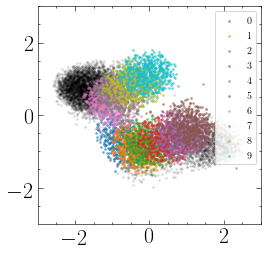

In [6]:
# plt hills 
os.chdir(path + "/DATA_examples/Invernizzi_plot_simulations")

plt.figure(figsize=(4,4))
n_old_sim = 10
for i in range(20-n_old_sim): 
    HILLS=MFI.load_HILLS_2D(hills_name="HILLSinve_" + str(i))
    # plt.plot(HILLS[:,1],HILLS[:,2], 'o', mfc='none')
    plt.scatter(HILLS[:,1],HILLS[:,2], s=3, c="black", alpha=0.1)

# os.chdir(path + "/DATA_examples/Invernizzi_2D_potential_more_data/HP_forces_s0.1_k20")
# hp_centre = [[-1.2,-1.2],[-0.8, -0.8],[-0.6,-0.6],[-0.4,-0.4],[-0.2,-0.2],[0,0],[0.2,0.2],[0.4,0.4], [0.6, 0.6], [-1.0,-1.0]]

# for simulation in [0,1,2,9]:#np.arange(0,len(hp_centre)):   
for simulation in np.arange(0,len(hp_centre)):   
    HILLS=MFI.load_HILLS_2D(hills_name="HILLSinve_HP_"+str(simulation))
    plt.scatter(HILLS[:,1],HILLS[:,2], s=3, label=str(simulation), alpha=0.5)
    
plt.xlim(-3,3); plt.ylim(-3,3); plt.legend(fontsize=10); plt.show()


### Plots

In [4]:
#load results for plotting
#MFI.save_pkl([[FES_1, Ftot_den_1, ofe_1, AD_1, cutoff_1, time_history_1, ofe_history_1, aad_history_1], [FES_2, Ftot_den_2, ofe_2, AD_2, cutoff_2, time_history_2, ofe_history_2, aad_history_2], [FES_3, Ftot_den_3, ofe_3, AD_3, cutoff_3, time_history_3, ofe_history_3, aad_history_3]], "/home/ucecabj/Desktop/pyMFI_git/DATA_examples/Invernizzi_2D_potential_more_data/plot_results.pkl")
[FES_1, Ftot_den_1, ofe_1, AD_1, cutoff_1, time_history_1, ofe_history_1, aad_history_1], [FES_2, Ftot_den_2, ofe_2, AD_2, cutoff_2, time_history_2, ofe_history_2, aad_history_2], [FES_3, Ftot_den_3, ofe_3, AD_3, cutoff_3, time_history_3, ofe_history_3, aad_history_3] = MFI.load_pkl(path_manustript + "Figure3/plot_results.pkl")

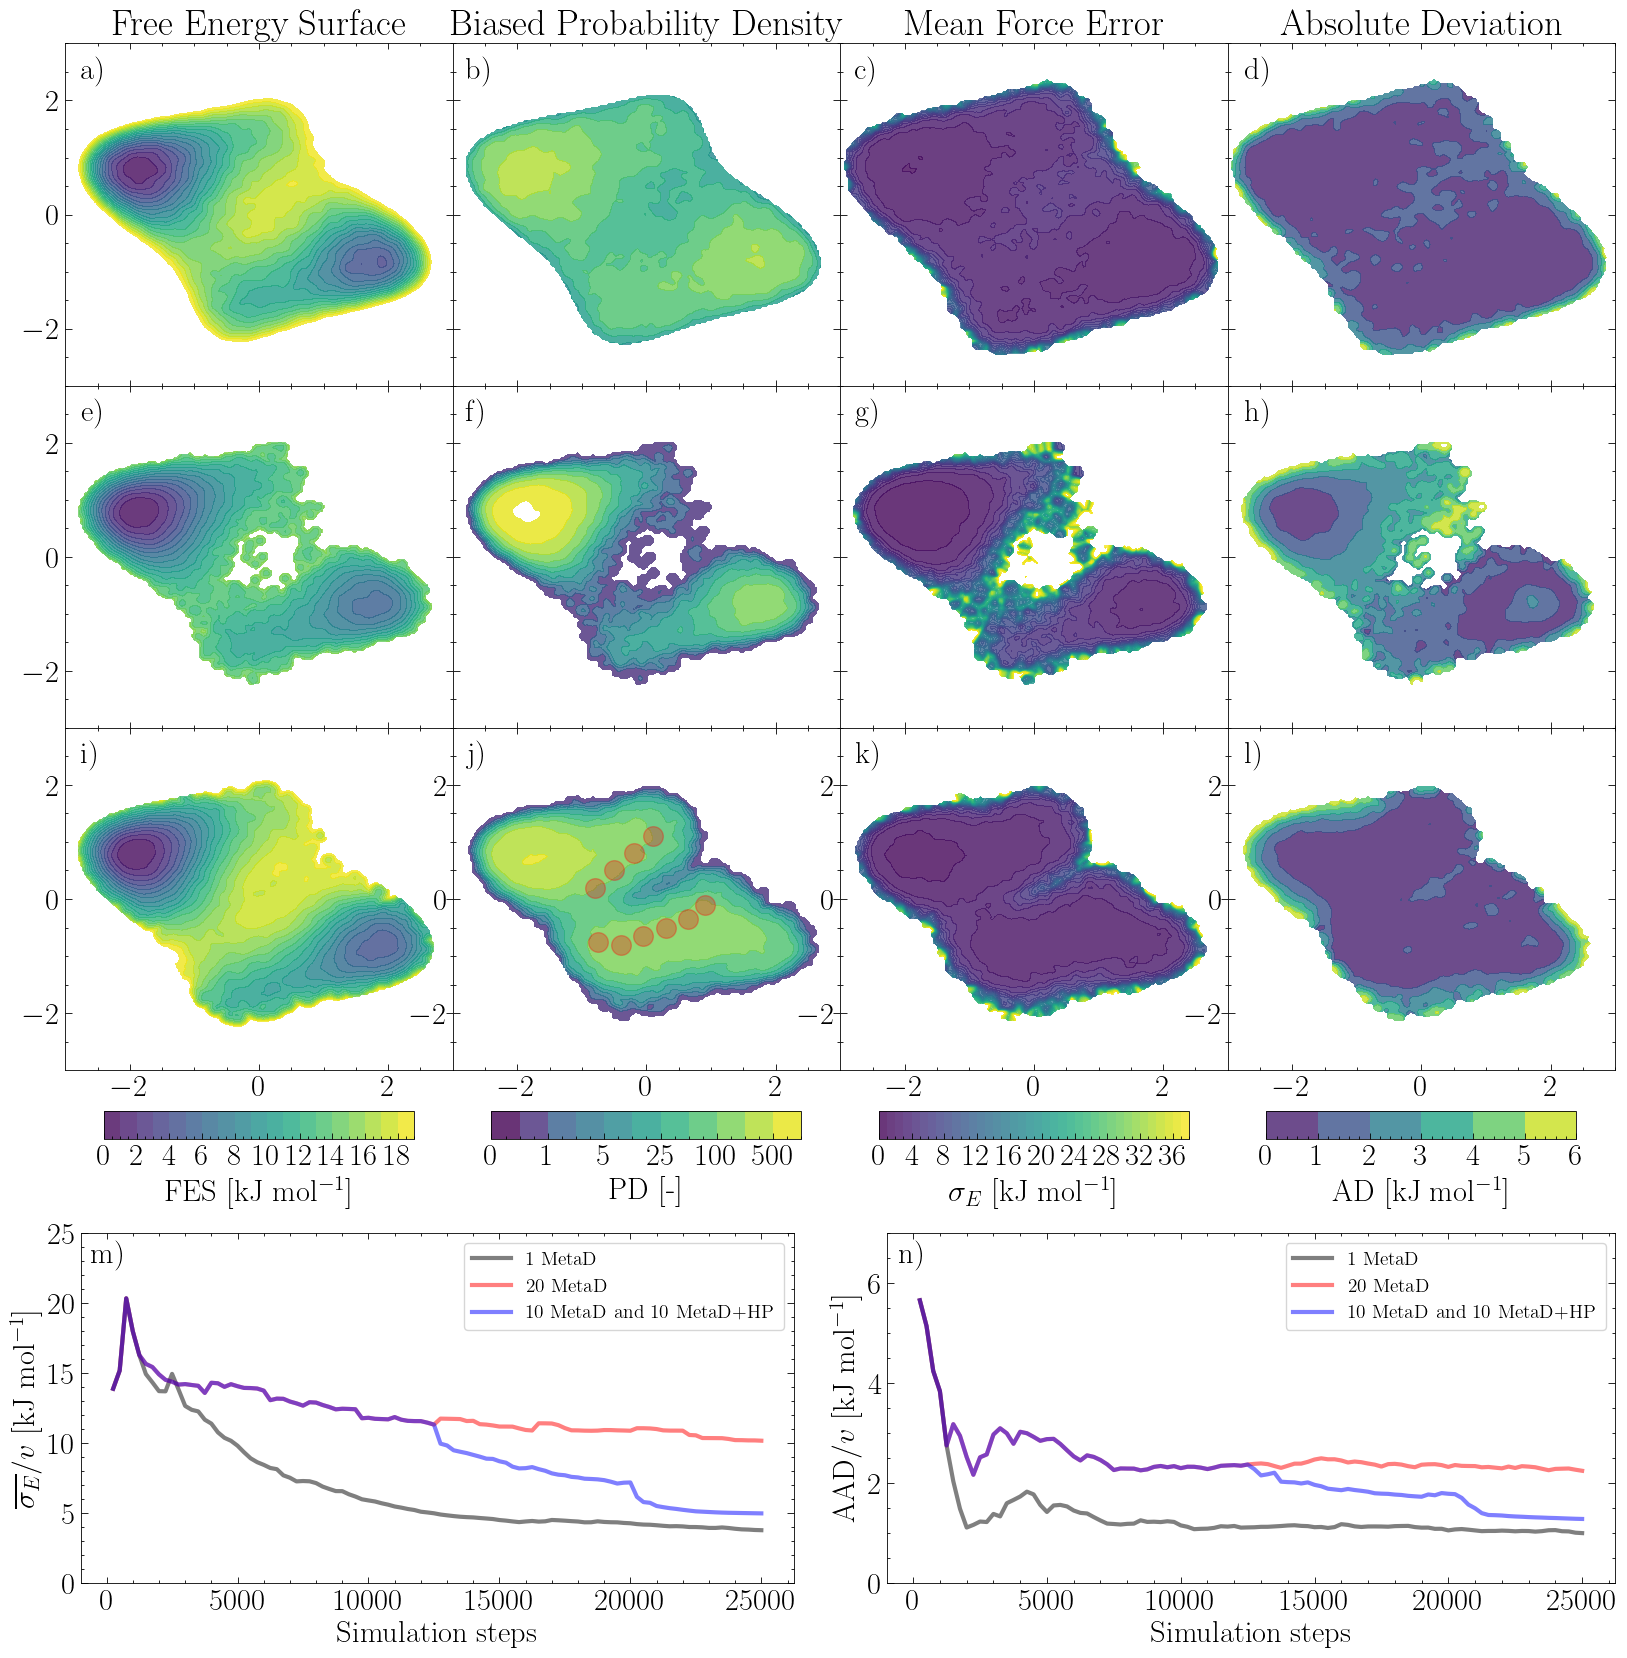

In [15]:
# Prid plot (3x4 with Ftot_den + 1x2 error)
cutoff_inve19 = np.where(inve_pot < 19, 1, 0)
plt_list = [np.where(inve_pot < 22, FES_1, np.nan), np.where(np.logical_and(Ftot_den_1>1E-1 , inve_pot < 22 ), Ftot_den_1,np.nan), MFI.zero_to_nan(ofe_1), MFI.zero_to_nan(AD_1), 
            np.where(np.logical_and(Ftot_den_2>1E-1 , inve_pot < 22 ), FES_2, np.nan), np.where(np.logical_and(Ftot_den_2>1E-1 , inve_pot < 22 ), Ftot_den_2,np.nan), np.where(np.logical_and(inve_pot < 22, ofe_2 > 0), ofe_2, np.nan), MFI.zero_to_nan(AD_2), 
            np.where(inve_pot < 22, FES_3, np.nan), np.where(np.logical_and(Ftot_den_3>1E-1 , inve_pot < 22 ), Ftot_den_3,np.nan), MFI.zero_to_nan(ofe_3), MFI.zero_to_nan(AD_3)]
levels_list = [np.arange(0, 20, 1), [0.01, 0.1, 1, 2.5, 5, 10, 25, 50, 100, 225, 500, 1000], np.arange(0, 39, 1), np.arange(0, 7, 1)]
# levels_list = [np.arange(0, 20, 1), [0.01, 0.1, 1, 2.5, 5, 10, 25, 50, 100, 225, 500, 1000], [20,21,22,23,24,25,26,27,28,29,30,40,50], np.arange(0, 7, 1)]
levels_list = levels_list + levels_list + levels_list
               
PD_tick_loc = [0.01, 0.055, 0.1, 0.55, 1, 1.75, 2.5, 3.75, 5, 7.5, 10, 17.5, 25, 37.5, 50, 75, 100, 162.5, 225, 362.5, 500, 750, 1000]
cbar_loc = [0,0,0,0,0,0,0,0,  -3, -2, -1, 0]
cbar_label = ["","","","","","","","",  "FES [kJ mol$^{-1}$]", "PD [-]", "$\sigma_E$ [kJ mol$^{-1}$]", "AD [kJ mol$^{-1}$]"]
title_list = ["Free Energy Surface", "Biased Probability Density", "Mean Force Error",  "Absolute Deviation"]

d=0.2
hp_centre = [[-0.75,-0.75], [-0.6+d, -0.6-d],[-0.35+1.5*d,-0.35-1.5*d],[-0.1+2*d,-0.1-2*d],[0.15+2.5*d,0.15-2.5*d], [0.4+2.5*d, 0.4-2.5*d], [-0.3-2.5*d,-0.3+2.5*d],[-0-2.5*d,-0+2.5*d],[0.3-2.5*d,0.3+2.5*d],[0.6-2.5*d,0.6+2.5*d]]  #AAD 1.19 k=35 d=0.2

fig = plt.figure(figsize=(20,20))

# Define the GridSpec with a spacer
gs = gridspec.GridSpec(5, 4, height_ratios=[1, 1, 1, 0.5, 1])

ax = []

# Create subplots for the first 3 rows with shared axes
for i in range(3):
    for j in range(4):
        if i == 0 and j == 0:
            ax.append(fig.add_subplot(gs[i, j]))
        else:
            ax.append(fig.add_subplot(gs[i, j], sharex=ax[0], sharey=ax[0]))

# Create the subplot for the fifth row (after the spacer)
# ax.append(fig.add_subplot(gs[4, :]))

# Plot the sample data on each of the subplots
for axis in range(len(ax[:-4])):
    if axis == 1 or axis == 5 : ax[axis].contourf(X,Y, plt_list[axis], levels=levels_list[axis], cmap='viridis', antialiased=False, alpha=0.8, norm=colors.LogNorm(vmin=0.1, vmax=1000))
    else: ax[axis].contourf(X,Y, plt_list[axis], levels=levels_list[axis], cmap='viridis', antialiased=False, alpha=0.8)
    if axis < 4: ax[axis].set_title(title_list[axis])
    
for axis in range(len(ax))[-4:]:
    if axis == 9: 
        contour = ax[axis].contourf(X,Y, plt_list[axis], levels=levels_list[axis], cmap='viridis', antialiased=False, alpha=0.8, norm=colors.LogNorm(vmin=0.1, vmax=1000))    
        axins = inset_axes(ax[axis], width="80%", height="8%", loc='lower center', bbox_to_anchor=(cbar_loc[axis], -1/5, 1, 1), bbox_transform=ax[-1].transAxes, borderpad=0)
        cbar = fig.colorbar(contour, cax=axins, orientation='horizontal', label=cbar_label[axis])
        cbar.ax.xaxis.set_minor_locator(ticker.FixedLocator(PD_tick_loc))
    else: 
        contour = ax[axis].contourf(X,Y, plt_list[axis], levels=levels_list[axis], cmap='viridis', antialiased=False, alpha=0.8)    
        axins = inset_axes(ax[axis], width="80%", height="8%", loc='lower center', bbox_to_anchor=(cbar_loc[axis], -1/5, 1, 1), bbox_transform=ax[-1].transAxes, borderpad=0)
        fig.colorbar(contour, cax=axins, orientation='horizontal', label=cbar_label[axis])

for j in [9]: 
    for i in range(len(hp_centre)): ax[j].scatter(hp_centre[i][0], hp_centre[i][1], c="r", alpha=0.3, s=200)

# ax = ax[:-1]
gs = gridspec.GridSpec(5, 100, height_ratios=[1, 1, 1, 0.4, 1])
ax.append(fig.add_subplot(gs[4, 1:47]))
ax.append(fig.add_subplot(gs[4, 53:]))

# ax[-2].plot( time_history_1, np.asarray(ofe_history_1) / np.asarray(volume_history_1),color='black',alpha=0.5,linewidth=3,label="Single Long Simulation")
# ax[-2].plot( time_history_2, np.asarray(ofe_history_2) / np.asarray(volume_history_2) ,color='red',alpha=0.5,linewidth=3,label="20 short MetaD Simulations")
# ax[-2].plot( time_history_3, np.asarray(ofe_history_3) / np.asarray(volume_history_3) ,color='blue',alpha=0.5,linewidth=3,label="10 MetaD and 10 MetaD+HP Simulations")

ax[-2].plot( time_history_1, np.asarray(ofe_history_1),color='black',alpha=0.5,linewidth=3,label="1 MetaD")
ax[-2].plot( time_history_2, np.asarray(ofe_history_2) ,color='red',alpha=0.5,linewidth=3, label="20 MetaD")
ax[-2].plot( time_history_3, np.asarray(ofe_history_3) ,color='blue',alpha=0.5,linewidth=3,label="10 MetaD and 10 MetaD+HP")

ax[-2].set_xlabel("Simulation steps"); ax[-2].set_ylabel("$\overline{\sigma_E}/ v$  [kJ mol$^{-1}$]")
ax[-2].set_ylim(0,25); 
ax[-2].legend(fontsize=14);

# ax[-1].plot( time_history_1, np.asarray(aad_history_1) / np.asarray(volume_history_1) ,color='black',alpha=0.5,linewidth=3,label="Single Long Simulation")
# ax[-1].plot( time_history_2, np.asarray(aad_history_2) / np.asarray(volume_history_2) ,color='red',alpha=0.5,linewidth=3,label="20 short MetaD Simulations")
# ax[-1].plot( time_history_3, np.asarray(aad_history_3) / np.asarray(volume_history_3) ,color='blue',alpha=0.5,linewidth=3,label="10 MetaD and 10 MetaD+HP Simulations")

ax[-1].plot( time_history_1, np.asarray(aad_history_1)[:,1],color='black',alpha=0.5,linewidth=3,label="1 MetaD")
ax[-1].plot( time_history_2, np.asarray(aad_history_2)[:,1],color='red',alpha=0.5,linewidth=3,  label="20 MetaD")
ax[-1].plot( time_history_3, np.asarray(aad_history_3)[:,1],color='blue',alpha=0.5,linewidth=3, label="10 MetaD and 10 MetaD+HP")
ax[-1].set_xlabel("Simulation steps"); 
ax[-1].set_ylabel("AAD$/v$ [kJ mol$^{-1}$]")
ax[-1].set_ylim(0,7); 
ax[-1].legend(fontsize=14);


for i in range(9):
    if i % 4 != 0: plt.setp(ax[i].get_yticklabels(), visible=False)
    if i < 8: plt.setp(ax[i].get_xticklabels(), visible=False)
    # ax[i].tick_params(left=False, right=False, bottom=False, top=False)
    
h_text = [0.862, 0.691, 0.52, 0.27]
w_text = [0.133, 0.325, 0.52, 0.715]
fig.text(w_text[0], h_text[0], "a)"); fig.text(w_text[1], h_text[0], "b)"); fig.text(w_text[2], h_text[0], "c)"); fig.text(w_text[3], h_text[0], "d)")
fig.text(w_text[0], h_text[1], "e)"); fig.text(w_text[1], h_text[1], "f)"); fig.text(w_text[2], h_text[1], "g)"); fig.text(w_text[3], h_text[1], "h)")
fig.text(w_text[0], h_text[2], "i)"); fig.text(w_text[1], h_text[2], "j)"); fig.text(w_text[2], h_text[2], "k)"); fig.text(w_text[3], h_text[2], "l)")
fig.text(w_text[0]+0.005, h_text[3], "m)")
fig.text(w_text[2]+0.022, h_text[3], "n)")

plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig(path_manustript + 'Figure3/Figure3.png', dpi=600, bbox_inches='tight')

plt.show()